# Predicting Blood Donations

This competition was chosen as a warm up to data science competitions on DrivenData. We will be experimenting with a couple of different classifier algorithms and see which one performs best with the dataset. 

We'll start with importing key libraries that will be used during the predictive modeling.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#utilities

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from scipy.stats import randint


# Load in the blood donation data
df = pd.read_csv('blood_donation_train.csv', index_col=0)


# Exploratory Analysis

In [2]:
df.head()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [3]:
df.describe()

,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


With the scatter matrix we will be able to see all the features interact with one another. This way we can discover interesting relationships between the predictors and the outcome. In this case you will see that the number of donations and total volume of blood donated is strongly correlated (This makes a lot of sense). This finding tells us to remove one of them since correlated predictors have been known to negatively affect the accuracy.

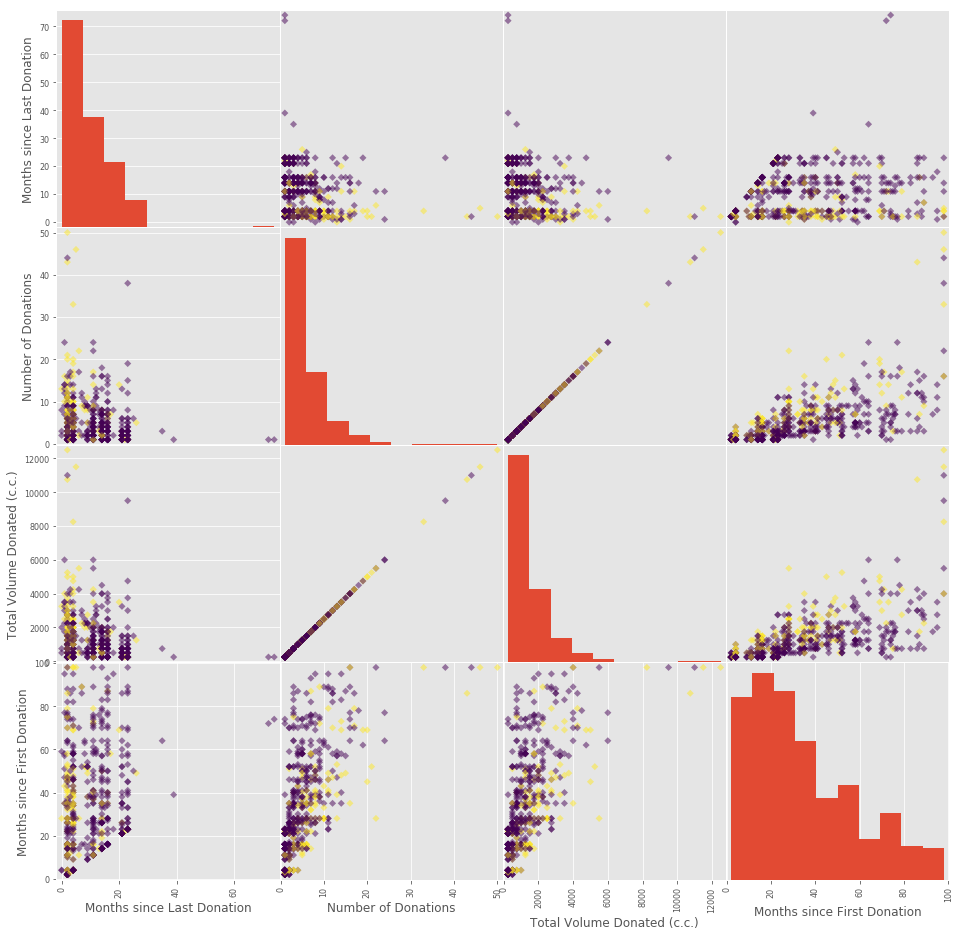

In [4]:
X1 = df.iloc[:,:4]
y1 = df.iloc[:, -1]

plt.style.use('ggplot')
_ = pd.plotting.scatter_matrix(X1, figsize=(16,16), c=y1, marker='D', s=25)

# Preprocessing

As seen above in the summary statistics cell, we will have to scale the data since the numbers are too spread apart. The scaling method was selected based on how well they would complement the corresponding algorithms. 

In [5]:
X = df.iloc[:,:4]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42, stratify=y)

#Rescaled Data for algorithms that use distance measures like knn
min_max = MinMaxScaler(feature_range=(0, 1))
X_train_mm = min_max.fit_transform(X_train)
X_test_mm = min_max.fit_transform(X_test)

#Rescaled data for models that have attributes with a Gaussian distribution like logistic regression and linear regression
X_train_scaled = StandardScaler().fit(X_train)
X_train_ss = X_train_scaled.transform(X_train)
X_test_scaled = StandardScaler().fit(X_test)
X_test_ss = X_train_scaled.transform(X_test)

#Rescaled data for sparse datasets(lots of zeroes). good for neural networks and knn
norm = Normalizer().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)


# Hypertuning Parameters

Here we will define a function to calculate the best parameters for each one of the following algorithms we will be experimenting with

In [21]:
def tuning(m):
    if m=='knn':
        model_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='neg_log_loss')
        model_cv.fit(X_train_mm, y_train)
    elif m=='logreg':
        model_cv = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='neg_log_loss')
        model_cv.fit(X_train_ss, y_train) 
    elif m=='tree': 
        model_cv = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='neg_log_loss')
        model_cv.fit(X_train, y_train)
    elif m=='svm':
        model_cv = GridSearchCV(SVC(), param_grid, cv=3, scoring='neg_log_loss')
        model_cv.fit(X_train_ss, y_train)
        
    else:
        return print('ERROR: There was a problem with the parameter input')
    print("Tuned model parameters: {}".format(model_cv.best_params_)) 
    print("Best score is {}".format(-model_cv.best_score_))
    return model_cv


Now we will define our models and call the hyper parameter tuning function above to find the most optimal parameters to achieve a high prediction accuracy. Keep in mind that the metric we'll be using to measure performance is log loss, so our goal will be to keep it as low as possible.

# Model - KNeighborsClassifier

In [31]:
param_grid = {'n_neighbors': np.arange(1, 40)}
model_knn = tuning(m='knn')
y_pred_knn = model_knn.predict_proba(X_train_mm)[:,1]

Tuned model parameters: {'n_neighbors': 33}
Best score is 0.4779421399222596


# Model - LogisticRegression

In [30]:
param_grid = {'C': np.logspace(-5, 5, 1000), 'penalty': ['l1', 'l2']}
model_lr = tuning(m='logreg')
y_pred_lr = model_lr.predict_proba(X_train_ss)[:, 1]

Tuned model parameters: {'C': 0.5555776222398878, 'penalty': 'l2'}
Best score is 0.4830964664186544


# Model - DecisionTreeClassifier

In [32]:
param_grid = {"max_depth": [3, None],
              "max_features": randint(1, 5),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

model_tree = tuning(m='tree')
y_pred_tree = model_tree.predict_proba(X_train)[:, 1]

Tuned model parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 2}
Best score is 0.6765241340754703


# Model - SVM

In [33]:
param_grid ={'C':np.arange(1,11),
             'gamma':np.logspace(-5, 4, 500),
             'probability':[True]}
model_svm = tuning(m='svm')
y_pred_svm = model_svm.predict_proba(X_train_ss)[:, 1]

Tuned model parameters: {'C': 1, 'gamma': 0.43178797273320213, 'probability': True}
Best score is 0.48892841369876655


# Model Performance Calculator

We'll be using the AUC-ROC  method to measure the performance of each of the models and select the one that does the best to use on the test data. The model with the best performance will have highest area under the curve representing a model that is able to classify donors and non-donors correctly. The ideal model will have an area of 1 meaning that all the predictions are correct but most models won't look like that.

It turns out that the k nearest neighbors is the best performing model but it just barely out performs the logistic regression model. We will end up using the k nearest neighbors on the testing data and see how it compares to the log loss on the training data

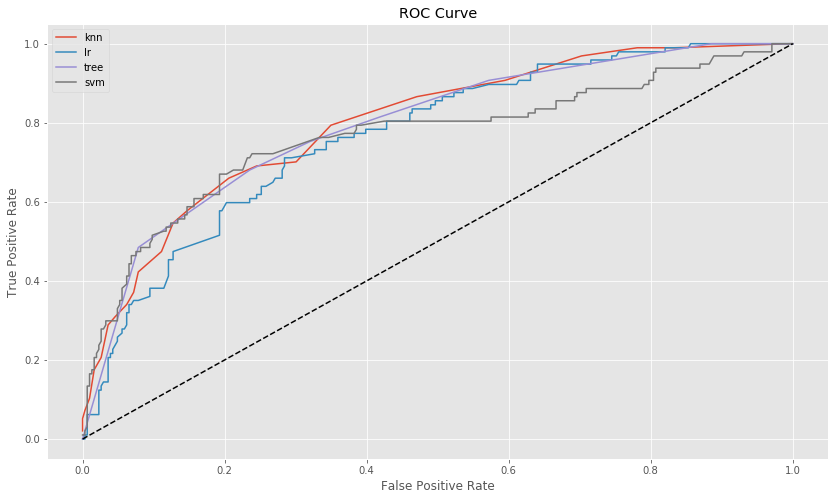

In [35]:
# KNN
fpr, tpr, thresholds = roc_curve(y_train, y_pred_knn)
# Logistic Regression
fpr2, tpr2, threshold2 = roc_curve(y_train, y_pred_lr)
# Decision Tree
fpr3, tpr3, thresholds3 = roc_curve(y_train, y_pred_tree)
# SVM
fpr4, tpr4, thresholds4 = roc_curve(y_train, y_pred_svm)
plt.figure(figsize=(14,8))

plt.plot(fpr, tpr)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot(fpr4, tpr4)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

models = ['knn', 'lr','tree', 'svm']
plt.legend(models)

# Score

In [36]:
y_test_pred =  model_knn.predict_proba(X_test_mm)[:,1]
score = log_loss(y_test, y_test_pred)
print('Log Loss = {}'.format(score))

Log Loss = 0.5387887934649129


The result is a test score just a little bit higher than the training score. This indicates that the model has a low variance, but may have a high bias, meaning that our model is too simple to explain a complex problem. One ways we could further improve on the model is to introduce feature engineering to possibly explain a deeper relationship in the data that wasn't before. 

We will forego this process since thhe purpose of this experimentation was just explore how each of the models worked and to try to improve on them. Reviewing the techniques that were used: We performed feature scaling to standardize our data, and then used hyperparameter tuning to minimize the log loss.

I hope you enjoyed the process!